# Requirements:

- Bring a dataset relevant to the project idea domain ✅
- Perform data preprocessing on the dataset ✅
- Train your neural network model ✅
- Apply modifications to the model ✅
- Evaluate your model on the testing dataset (Classification) ✅
- Use the model to make predictions on unseen examples ⌛ In progress. (I tried it manually with random numbers until gathering new data). Also, I used test data as unseen data if that is what he meant.
- Do Feature Importance on your model ✅
- Perform hyperparameter tuning and explain the new results ✅
- Visualize weights and biases after training  ✅

In [1]:

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


## Load and Explore the Dataset

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler

In [3]:

dataset = pd.read_csv('/kaggle/input/combined-network-faults-data/combined_network_faults_data.csv')



print(dataset.head())


   ('t0', 'T01')  ('t0', 'H01')  ('t0', 'T02')  ('t0', 'H02')  ('t1', 'T11')  \
0          30.21          43.82          30.16          43.05          30.20   
1          30.20          43.79          30.17          43.05          30.19   
2          30.19          43.79          30.17          43.05          30.19   
3          30.19          43.79          30.19          43.12          30.19   
4          30.19          43.79          30.18          43.09          30.19   

   ('t1', 'H11')  ('t1', 'T12')  ('t1', 'H12')  ('t2', 'T21')  ('t2', 'H21')  \
0          43.79          30.17          43.05          30.19          43.79   
1          43.79          30.17          43.05          30.19          43.79   
2          43.79          30.19          43.12          30.19          43.79   
3          43.79          30.18          43.09          30.19          43.79   
4          43.79          30.18          43.09          30.19          43.79   

   ('t2', 'T22')  ('t2', 'H22')       

In [4]:

print(dataset.isnull().sum())


('t0', 'T01')    4688
('t0', 'H01')    4688
('t0', 'T02')    4688
('t0', 'H02')    4688
('t1', 'T11')    4688
('t1', 'H11')    4688
('t1', 'T12')    4688
('t1', 'H12')    4688
('t2', 'T21')    4688
('t2', 'H21')    4688
('t2', 'T22')    4688
('t2', 'H22')    4688
0                   0
dtype: int64


In [5]:

dataset = dataset.dropna()

In [6]:
# Check for missing values after handling NaNs
print(dataset.isnull().sum())



('t0', 'T01')    0
('t0', 'H01')    0
('t0', 'T02')    0
('t0', 'H02')    0
('t1', 'T11')    0
('t1', 'H11')    0
('t1', 'T12')    0
('t1', 'H12')    0
('t2', 'T21')    0
('t2', 'H21')    0
('t2', 'T22')    0
('t2', 'H22')    0
0                0
dtype: int64


In [7]:

print(dataset['0'].value_counts())

0
normal          194456
Offset           35200
Gain             32856
Out of bound      7040
Stuck-at          7040
Name: count, dtype: int64


## Preprocess the Data

In [8]:
from imblearn.over_sampling import SMOTE


features = dataset.iloc[:, :-1]
target = dataset['0']

smote = SMOTE(sampling_strategy='auto')  # or a ratio like 0.5
X_resampled, y_resampled = smote.fit_resample(features, target)

# Check new class distribution
print(pd.Series(y_resampled).value_counts())

0
normal          194456
Gain            194456
Out of bound    194456
Offset          194456
Stuck-at        194456
Name: count, dtype: int64


In [9]:

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X_resampled)  

In [10]:

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_resampled)


one_hot_labels = to_categorical(encoded_labels, num_classes=5) 


# (1) Sequential Neural Network

## Build the Neural Network

In [11]:


X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, one_hot_labels, test_size=0.2, random_state=42
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


In [12]:

model = Sequential([
    Input(shape=(X_train.shape[1],)),  
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


## Train the Model

In [13]:

history = model.fit(
    X_train, y_train,  
    validation_data=(X_val, y_val),
    epochs=20, 
    batch_size=32,
    verbose=1
)

Epoch 1/20


I0000 00:00:1733576660.645661      90 service.cc:145] XLA service 0x7d6cbc006a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733576660.645720      90 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733576660.645727      90 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  109/19446 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - accuracy: 0.3553 - loss: 1.4476  

I0000 00:00:1733576664.384735      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19446/19446 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.8507 - loss: 0.3944 - val_accuracy: 0.9547 - val_loss: 0.1405
Epoch 2/20
19446/19446 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.9349 - loss: 0.1841 - val_accuracy: 0.9576 - val_loss: 0.1187
Epoch 3/20
19446/19446 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.9442 - loss: 0.1573 - val_accuracy: 0.9637 - val_loss: 0.1054
Epoch 4/20
19446/19446 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.9500 - loss: 0.1428 - val_accuracy: 0.9636 - val_loss: 0.0932
Epoch 5/20
19446/19446 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9541 - loss: 0.1310 - val_accuracy: 0.9653 - val_loss: 0.0934
Epoch 6/20
19446/19446 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.9571 - loss: 0.1239 - val_accuracy: 0.9754 - val_loss: 0.0842
Epoch 7/20
19446/19446 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9584 - loss: 0.1196 - val_accuracy: 0.9692 - val_loss: 0.0919
Epoch 8/20
19446/19446 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9598 - lo

##  Evaluate the Model

In [14]:

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


6077/6077 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9351 - loss: 0.1305
Test Accuracy: 93.50%


## Visualize the Performance

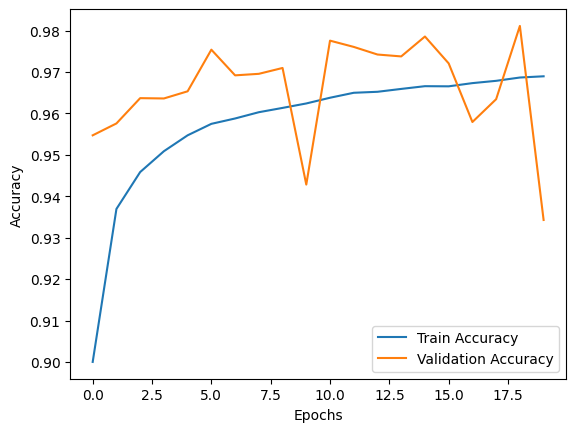

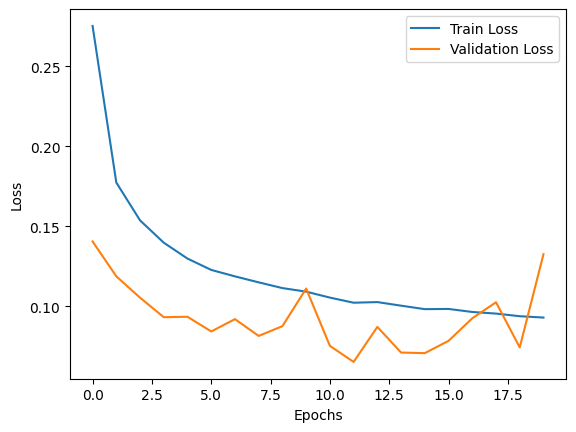

In [15]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Evaluate with Confusion Matrix and Classification Report

6077/6077 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


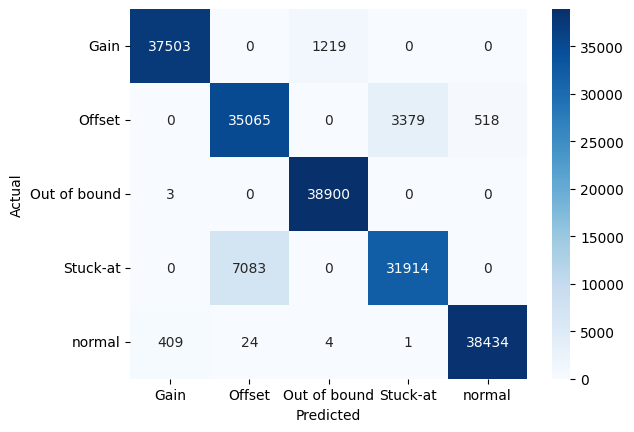

              precision    recall  f1-score   support

        Gain       0.99      0.97      0.98     38722
      Offset       0.83      0.90      0.86     38962
Out of bound       0.97      1.00      0.98     38903
    Stuck-at       0.90      0.82      0.86     38997
      normal       0.99      0.99      0.99     38872

    accuracy                           0.93    194456
   macro avg       0.94      0.94      0.93    194456
weighted avg       0.94      0.93      0.93    194456



In [16]:

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_true, y_pred)


sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


# (2)LSTM

In [17]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical

In [18]:
# Reshape the data for LSTM
# LSTM expects the input to be of shape (samples, time_steps, features)
# Since this is not a time-series dataset, I treat each sample as having one time step
X_resampled_reshaped = scaled_features.reshape((scaled_features.shape[0], 1, scaled_features.shape[1]))


X_train, X_test, y_train, y_test = train_test_split(
    X_resampled_reshaped, one_hot_labels, test_size=0.2, random_state=42
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


## Requirement 8: Hyperparameter Tuning


Testing configuration: LSTM Units=64, Dropout=0.3, LR=0.001


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Test Accuracy: 0.9776
Testing configuration: LSTM Units=64, Dropout=0.3, LR=0.01
Test Accuracy: 0.9208
Testing configuration: LSTM Units=64, Dropout=0.4, LR=0.001
Test Accuracy: 0.9692
Testing configuration: LSTM Units=64, Dropout=0.4, LR=0.01
Test Accuracy: 0.7868
Testing configuration: LSTM Units=128, Dropout=0.3, LR=0.001
Test Accuracy: 0.9801
Testing configuration: LSTM Units=128, Dropout=0.3, LR=0.01
Test Accuracy: 0.8357
Testing configuration: LSTM Units=128, Dropout=0.4, LR=0.001
Test Accuracy: 0.9780
Testing configuration: LSTM Units=128, Dropout=0.4, LR=0.01
Test Accuracy: 0.8298


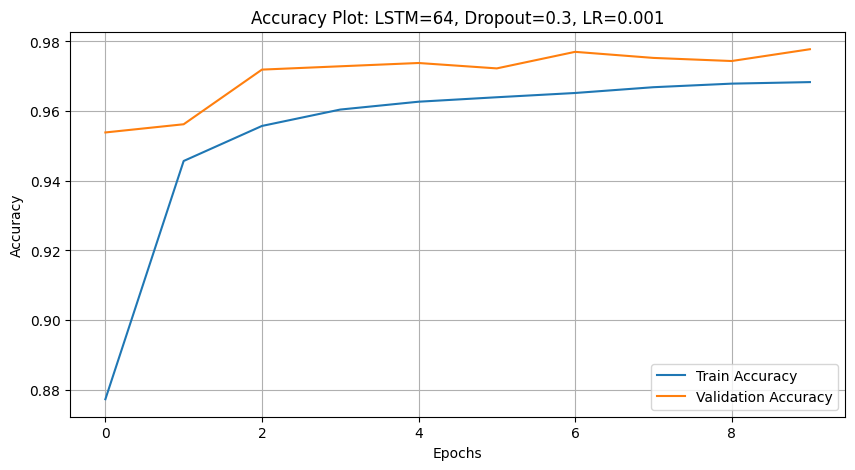

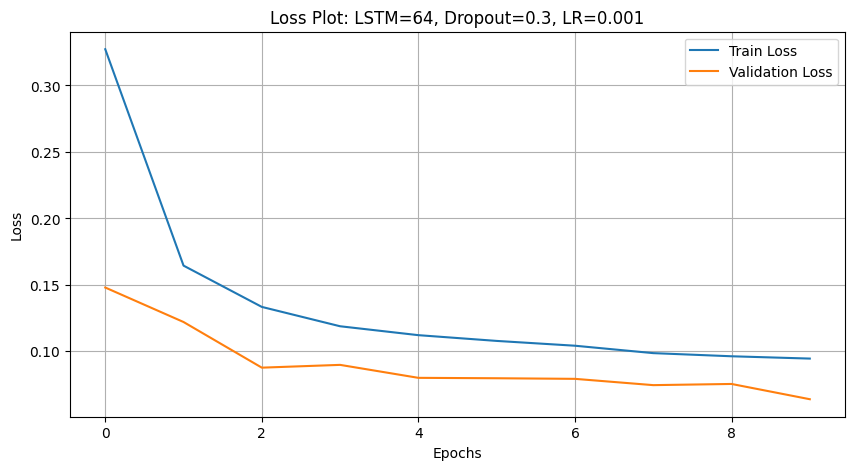

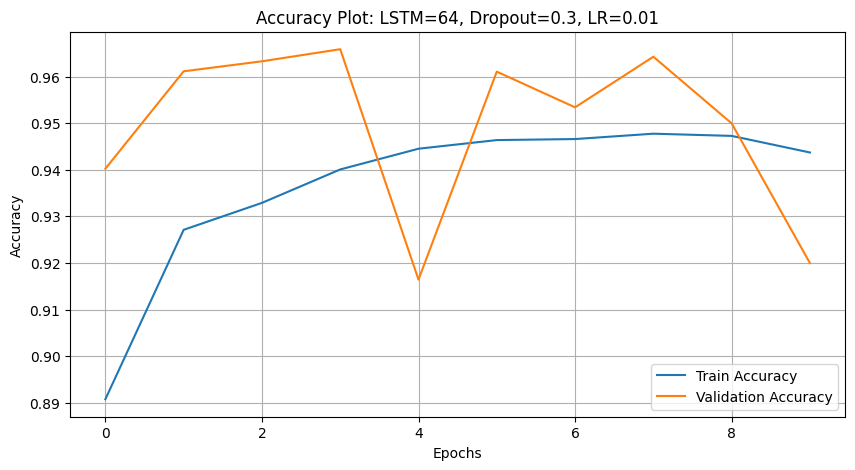

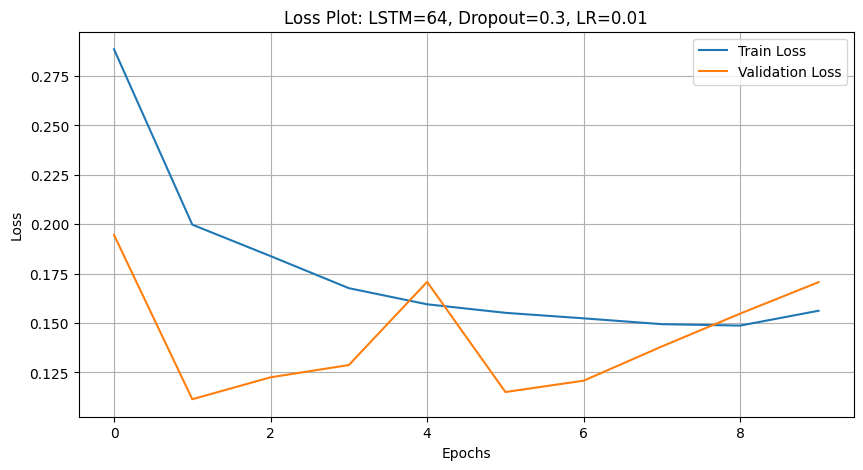

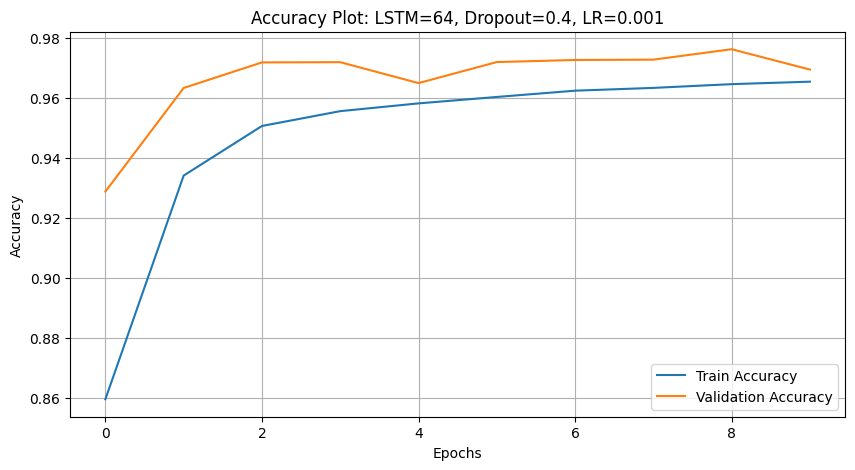

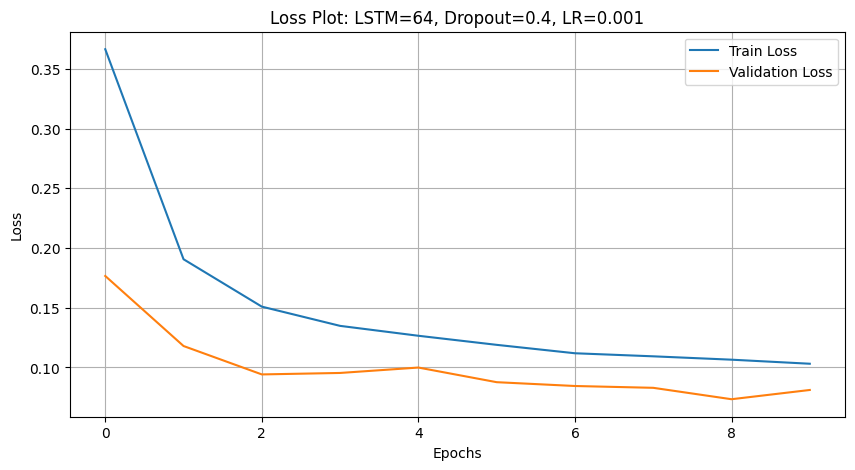

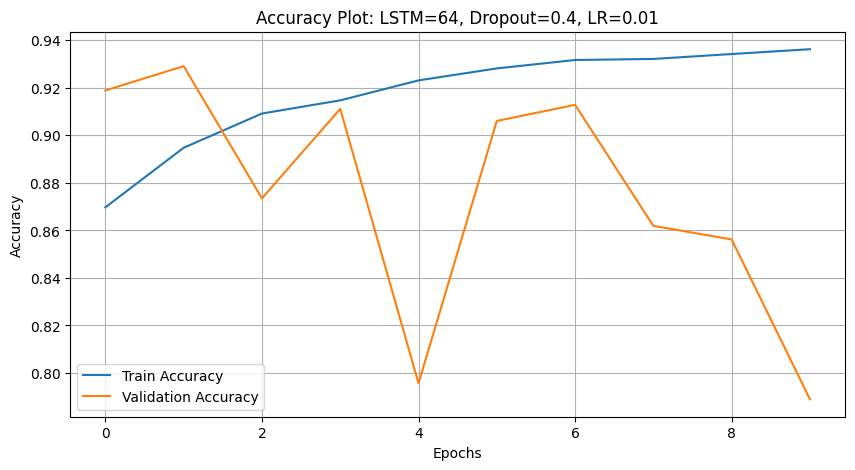

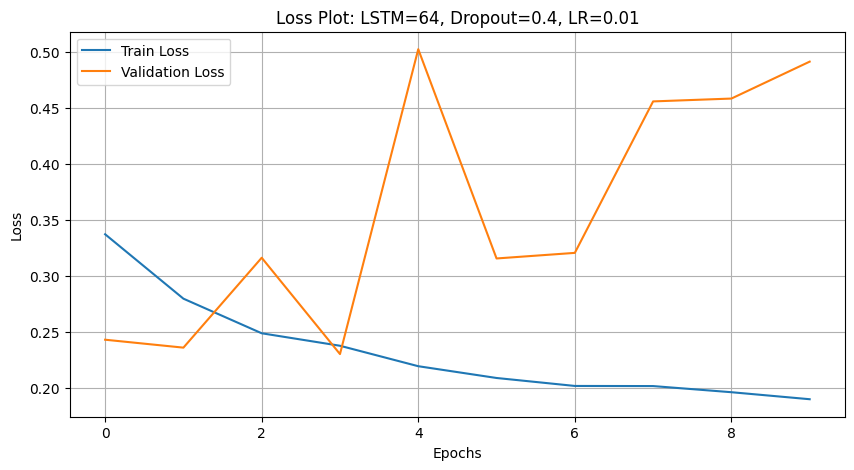

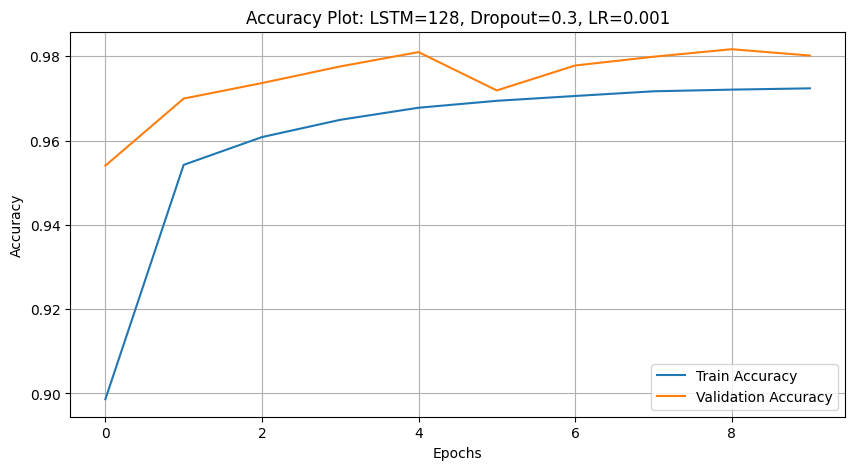

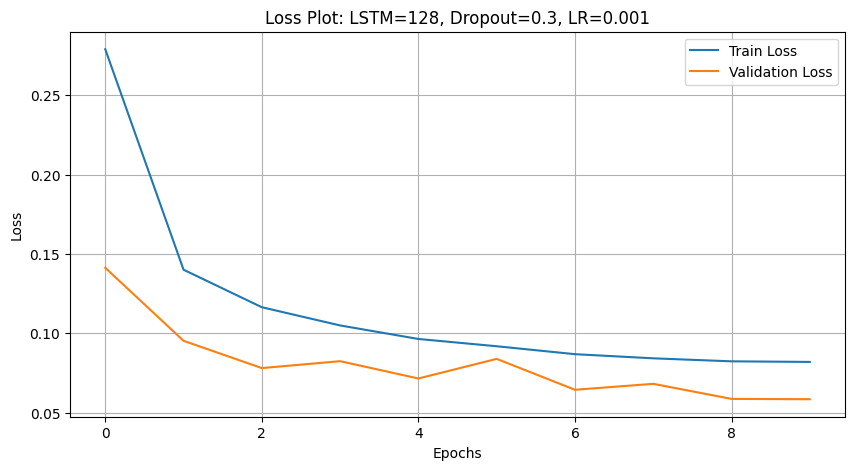

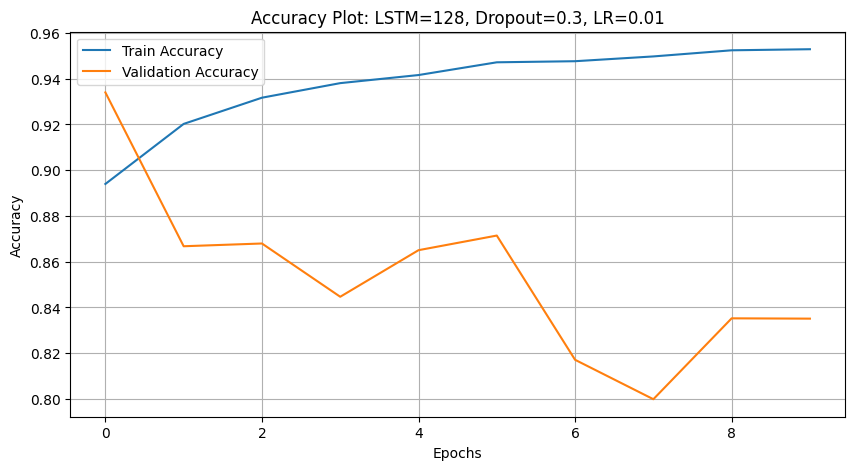

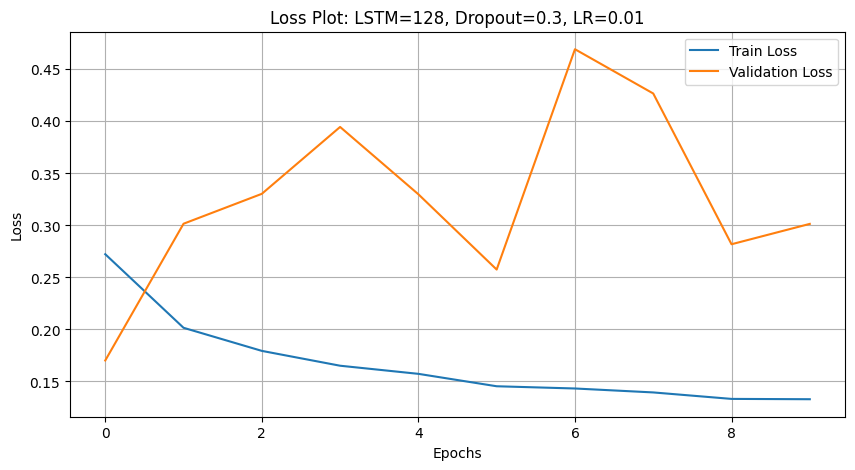

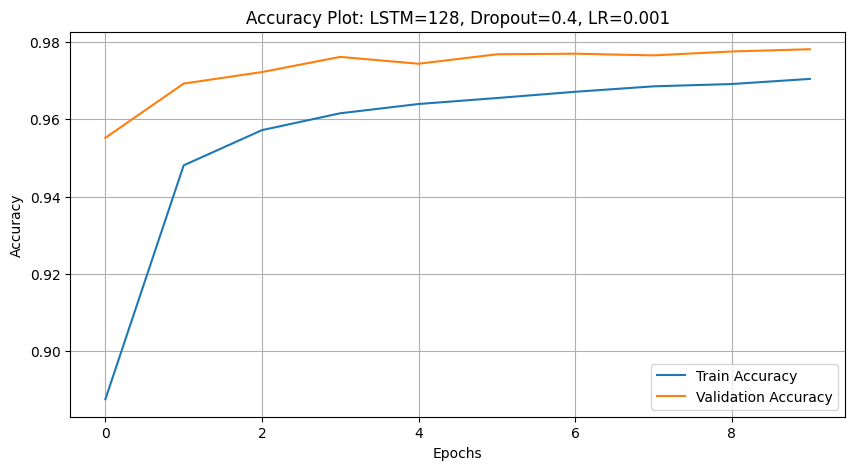

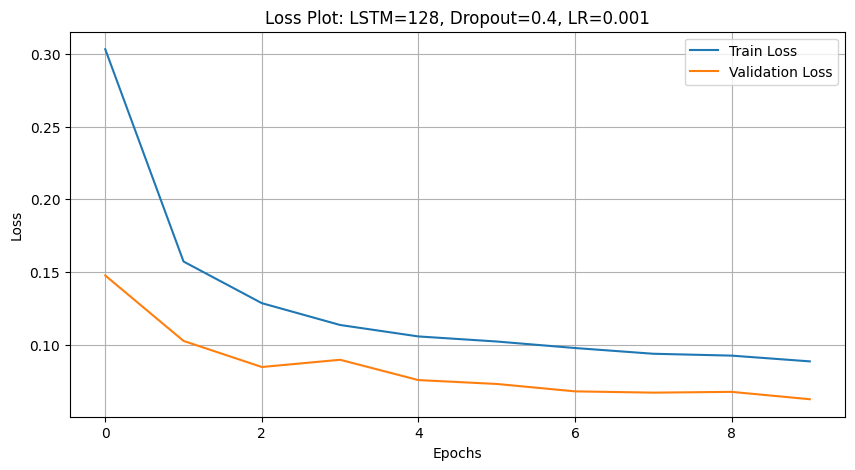

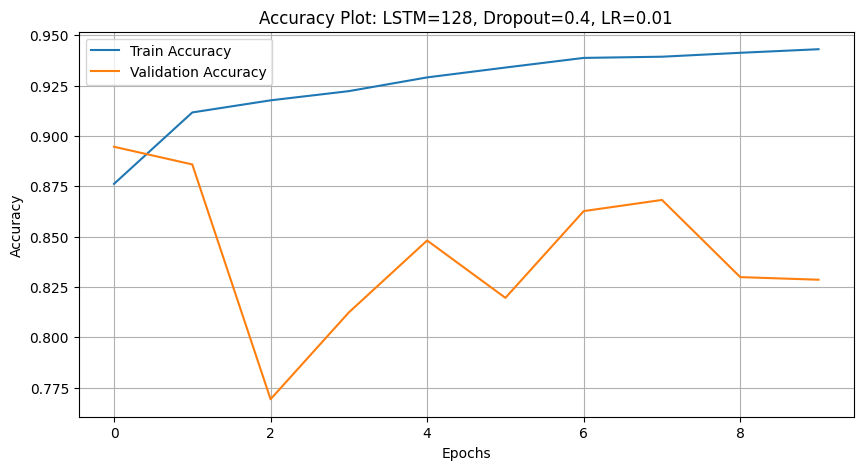

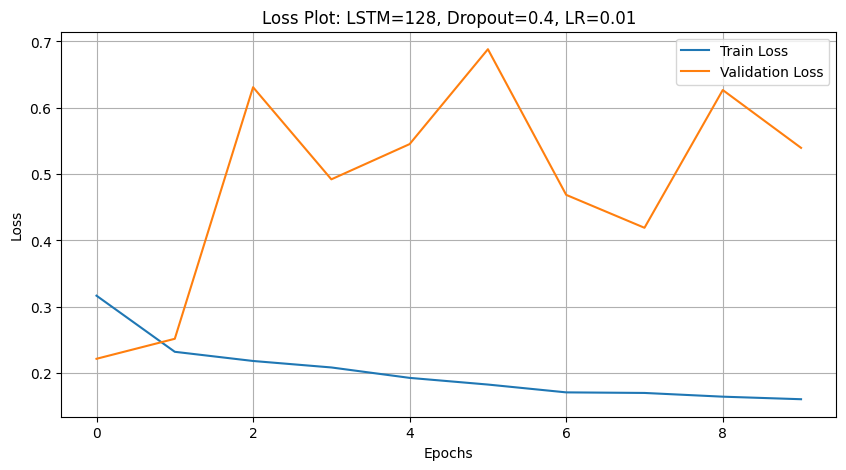

Best Parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.001}, Best Accuracy: 0.9801


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.inspection import permutation_importance
import seaborn as sns
import shap

best_accuracy = 0
best_params = None
param_grid = {
    'lstm_units': [64, 128],
    'dropout_rate': [0.3, 0.4],
    'learning_rate': [0.001, 0.01]
}

# Dictionary to store histories
histories = {}

for lstm_units in param_grid['lstm_units']:
    for dropout_rate in param_grid['dropout_rate']:
        for learning_rate in param_grid['learning_rate']:
            print(f"Testing configuration: LSTM Units={lstm_units}, Dropout={dropout_rate}, LR={learning_rate}")
            
            model = Sequential([
                LSTM(lstm_units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
                Dropout(dropout_rate),
                Dense(64, activation='relu'),
                Dense(5, activation='softmax')  
            ])
            
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
            
            # Train the model and store history
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=0)
            _, accuracy = model.evaluate(X_test, y_test, verbose=0)
            print(f"Test Accuracy: {accuracy:.4f}")
            
            # Store history for the current configuration
            config_name = f"LSTM={lstm_units}, Dropout={dropout_rate}, LR={learning_rate}"
            histories[config_name] = history
            
            # Update best parameters
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'lstm_units': lstm_units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}

# Plotting results
for config, history in histories.items():
    # Accuracy Plot
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy Plot: {config}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Plot: {config}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

print(f"Best Parameters: {best_params}, Best Accuracy: {best_accuracy:.4f}")


In [20]:
'''''
import matplotlib.pyplot as plt


best_train_accuracy = max(history.history['accuracy'])
best_val_accuracy = max(history.history['val_accuracy'])
best_train_loss = min(history.history['loss'])
best_val_loss = min(history.history['val_loss'])


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=history.history['accuracy'].index(best_train_accuracy), color='red', linestyle='--', label=f'Best Train Accuracy ({best_train_accuracy:.4f})')
plt.axvline(x=history.history['val_accuracy'].index(best_val_accuracy), color='green', linestyle='--', label=f'Best Validation Accuracy ({best_val_accuracy:.4f})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs with Best Accuracy')
plt.show()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axvline(x=history.history['loss'].index(best_train_loss), color='red', linestyle='--', label=f'Best Train Loss ({best_train_loss:.4f})')
plt.axvline(x=history.history['val_loss'].index(best_val_loss), color='green', linestyle='--', label=f'Best Validation Loss ({best_val_loss:.4f})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs with Best Loss')
plt.show()
'''''

"''\nimport matplotlib.pyplot as plt\n\n\nbest_train_accuracy = max(history.history['accuracy'])\nbest_val_accuracy = max(history.history['val_accuracy'])\nbest_train_loss = min(history.history['loss'])\nbest_val_loss = min(history.history['val_loss'])\n\n\nplt.plot(history.history['accuracy'], label='Train Accuracy')\nplt.plot(history.history['val_accuracy'], label='Validation Accuracy')\nplt.axvline(x=history.history['accuracy'].index(best_train_accuracy), color='red', linestyle='--', label=f'Best Train Accuracy ({best_train_accuracy:.4f})')\nplt.axvline(x=history.history['val_accuracy'].index(best_val_accuracy), color='green', linestyle='--', label=f'Best Validation Accuracy ({best_val_accuracy:.4f})')\nplt.xlabel('Epochs')\nplt.ylabel('Accuracy')\nplt.legend()\nplt.title('Accuracy Over Epochs with Best Accuracy')\nplt.show()\n\n\nplt.plot(history.history['loss'], label='Train Loss')\nplt.plot(history.history['val_loss'], label='Validation Loss')\nplt.axvline(x=history.history['loss

In [21]:
'''''
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_true, y_pred)

# Find the class with the highest true positives
best_class_index = np.argmax(np.diagonal(cm))  # Index of the class with the highest true positive
best_class_name = label_encoder.classes_[best_class_index]  # Name of the best class


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.gca().add_patch(plt.Rectangle((best_class_index, best_class_index), 1, 1, fill=False, edgecolor='green', lw=3))


plt.title(f'Confusion Matrix with Best Class: {best_class_name} (Highest True Positives)')
plt.show()


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
'''''

'\'\'\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nfrom sklearn.metrics import confusion_matrix, classification_report\nimport numpy as np\n\n\ny_pred = np.argmax(model.predict(X_test), axis=1)\ny_true = np.argmax(y_test, axis=1)\n\n\ncm = confusion_matrix(y_true, y_pred)\n\n# Find the class with the highest true positives\nbest_class_index = np.argmax(np.diagonal(cm))  # Index of the class with the highest true positive\nbest_class_name = label_encoder.classes_[best_class_index]  # Name of the best class\n\n\nplt.figure(figsize=(8, 6))\nsns.heatmap(cm, annot=True, fmt=\'d\', cmap=\'Blues\', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cbar=True)\nplt.xlabel(\'Predicted\')\nplt.ylabel(\'Actual\')\n\n\nplt.gca().add_patch(plt.Rectangle((best_class_index, best_class_index), 1, 1, fill=False, edgecolor=\'green\', lw=3))\n\n\nplt.title(f\'Confusion Matrix with Best Class: {best_class_name} (Highest True Positives)\')\nplt.show()\n\n\nprint("Classifica

## Requirement 9: Visualize Weights and Biases

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_weights_biases(model):
    for layer in model.layers:
        # Skip layers without weights
        if len(layer.get_weights()) == 0:
            continue
        
        weights = layer.get_weights()[0]  # Weights are the first element
        biases = layer.get_weights()[1] if len(layer.get_weights()) > 1 else None  
        
        plt.figure(figsize=(12, 6))
        
        
        sns.heatmap(weights, cmap='coolwarm', annot=False, cbar=True)
        plt.title(f"Layer: {layer.name} Weights")
        plt.show()

        # Plot biases if they exist
        if biases is not None:
            plt.figure(figsize=(12, 6))
            sns.heatmap(biases.reshape(1, -1), cmap='coolwarm', annot=False, cbar=True)
            plt.title(f"Layer: {layer.name} Biases")
            plt.show()


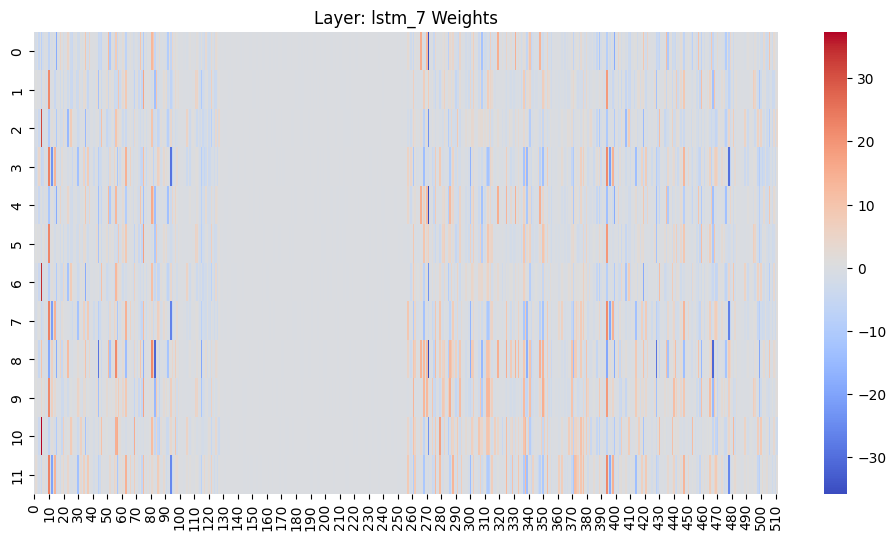

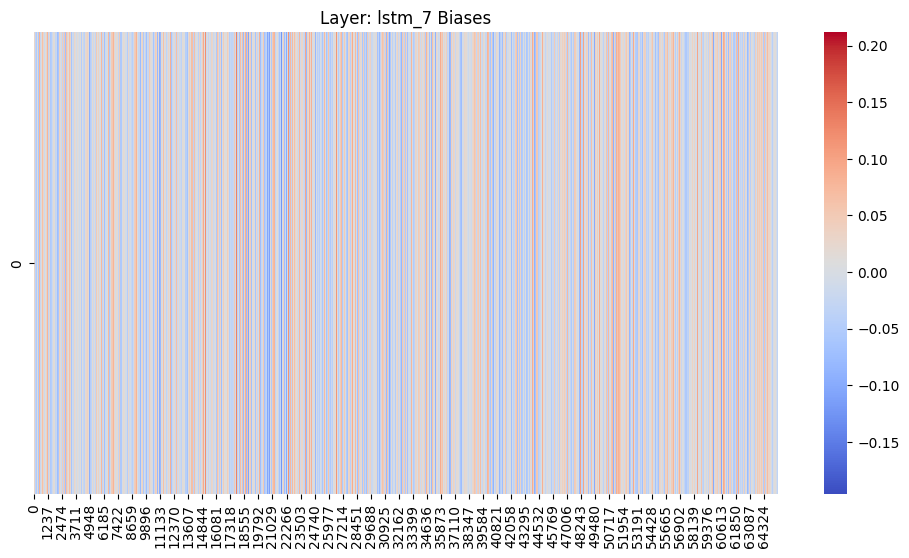

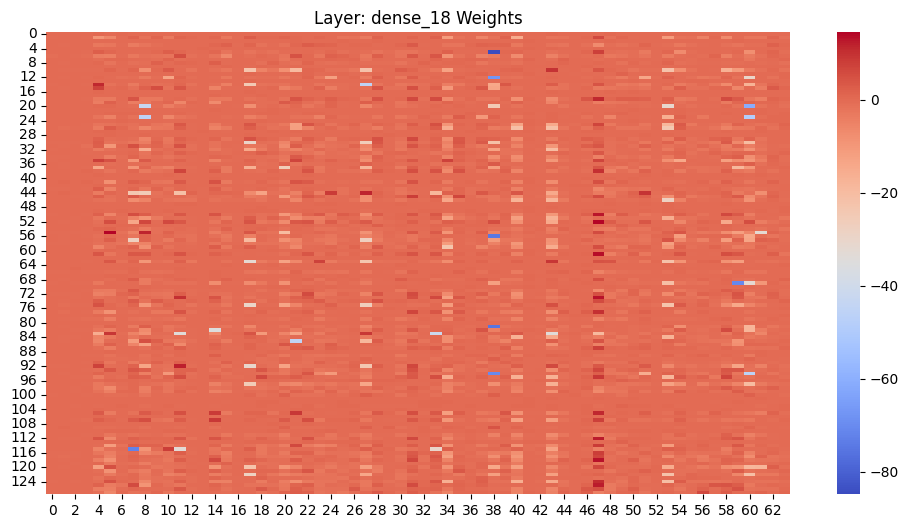

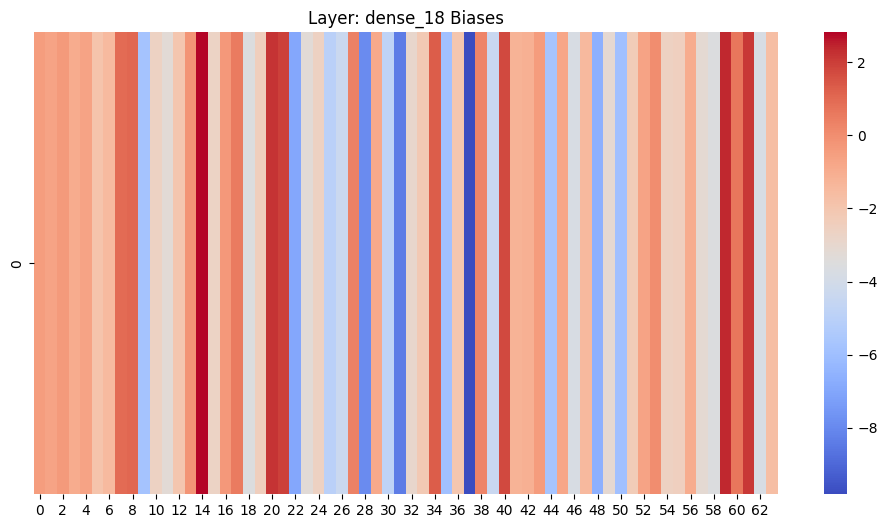

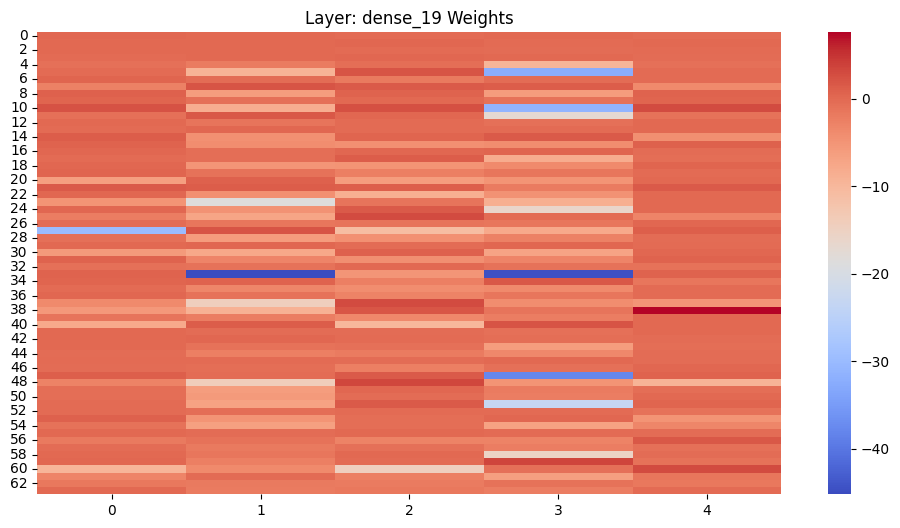

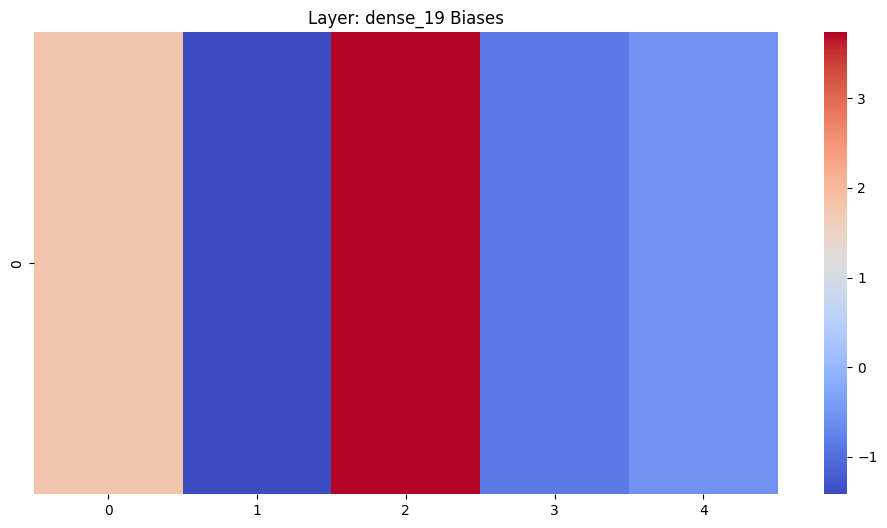

In [23]:
visualize_weights_biases(model)

## Requirement 7: Feature Importance

In [24]:
import shap
import numpy as np

# Define a prediction function for SHAP
def predict_fn(data):
    # Reshape data to match LSTM input format (samples, timesteps, features)
    data_reshaped = data.reshape(data.shape[0], X_val.shape[1], X_val.shape[2])
    return model.predict(data_reshaped)

# Flatten X_val for SHAP compatibility
X_val_flat = X_val.reshape(X_val.shape[0], -1)


explainer = shap.KernelExplainer(predict_fn, X_val_flat[:100])  


shap_values = explainer.shap_values(X_val_flat[:10])  




4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6475/6475 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


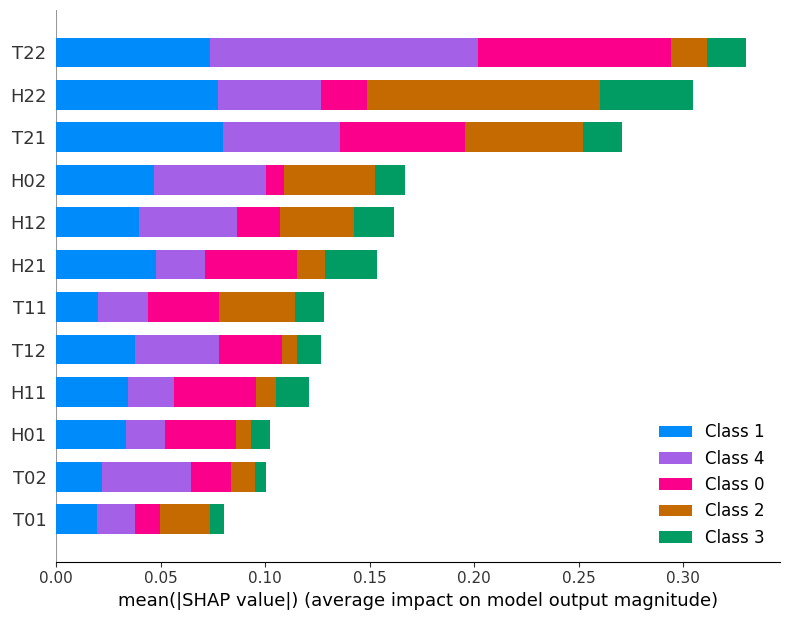

In [25]:

feature_names = ['T01', 'H01', 'T02', 'H02', 'T11', 'H11', 'T12', 'H12', 'T21', 'H21', 'T22', 'H22']


shap.summary_plot(shap_values, X_val_flat[:10], feature_names=feature_names)




In [26]:
'''

model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # Number of classes in the target
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

'''              

"\n\nmodel = Sequential([\n    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),\n    Dropout(0.4),\n    Dense(64, activation='relu'),\n    Dense(5, activation='softmax')  # Number of classes in the target\n])\n\n\nmodel.compile(optimizer='adam',\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\n\n"

In [27]:
'''   

history = model.fit(
    X_train, y_train,  # Use resampled train data
    validation_data=(X_val, y_val),
    epochs=20, 
    batch_size=32,
    verbose=1
)
'''   

'   \n\nhistory = model.fit(\n    X_train, y_train,  # Use resampled train data\n    validation_data=(X_val, y_val),\n    epochs=20, \n    batch_size=32,\n    verbose=1\n)\n'

In [28]:
'''   

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
'''   

'   \n\ntest_loss, test_accuracy = model.evaluate(X_test, y_test)\nprint(f"Test Accuracy: {test_accuracy * 100:.2f}%")\n'

# Apply Modifications to the model : 2- Deal with weight intialization.

Different Weight Initialization Methods for LSTM Networks

- Glorot Uniform (Xavier Initialization): Suitable for layers with ReLU activation.
- He Normal: Designed for ReLU activations, it helps with deeper networks.
- Orthogonal Initialization: Often used for RNNs, maintains orthogonality, which can improve convergence.
- Random Normal/Uniform: Basic initialization methods with specified standard deviation.
- LeCun Uniform: Effective for networks with sigmoid or softmax activations.

Analysis:
- Glorot and He initializers generally perform well with ReLU-based networks.
- Orthogonal can be beneficial for LSTMs by preserving gradient flow.
- Random normal and Lecun might be baseline references but may vary depending on activation functions.

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.initializers import GlorotUniform, HeNormal, Orthogonal, RandomNormal, LecunUniform

# Define initializers
initializers = {
    'glorot_uniform': GlorotUniform(),
    'he_normal': HeNormal(),
    'orthogonal': Orthogonal(),
    'random_normal': RandomNormal(mean=0.0, stddev=0.05),
    'lecun_uniform': LecunUniform()
}


Training with glorot_uniform initializer...

Epoch 1/20


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


19446/19446 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.8261 - loss: 0.4603 - val_accuracy: 0.9483 - val_loss: 0.1390
Epoch 2/20
19446/19446 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9450 - loss: 0.1624 - val_accuracy: 0.9683 - val_loss: 0.0991
Epoch 3/20
19446/19446 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9543 - loss: 0.1341 - val_accuracy: 0.9704 - val_loss: 0.0855
Epoch 4/20
19446/19446 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9610 - loss: 0.1158 - val_accuracy: 0.9761 - val_loss: 0.0798
Epoch 5/20
19446/19446 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9637 - loss: 0.1076 - val_accuracy: 0.9764 - val_loss: 0.0763
Epoch 6/20
19446/19446 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9657 - loss: 0.1014 - val_accuracy: 0.9757 - val_loss: 0.0765
Epoch 7/20
19446/19446 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9676 - loss: 0.0969 - val_accuracy: 0.9773 - val_loss: 0.0711
Epoch 8/20
19446/19446 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9688 - lo

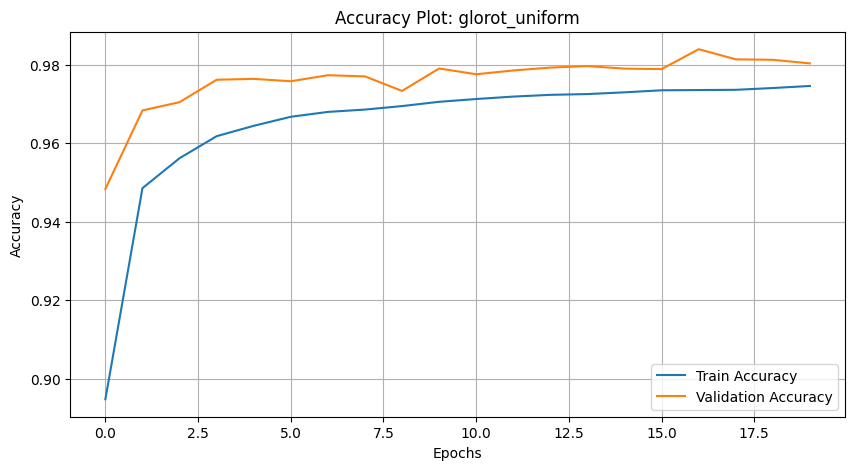

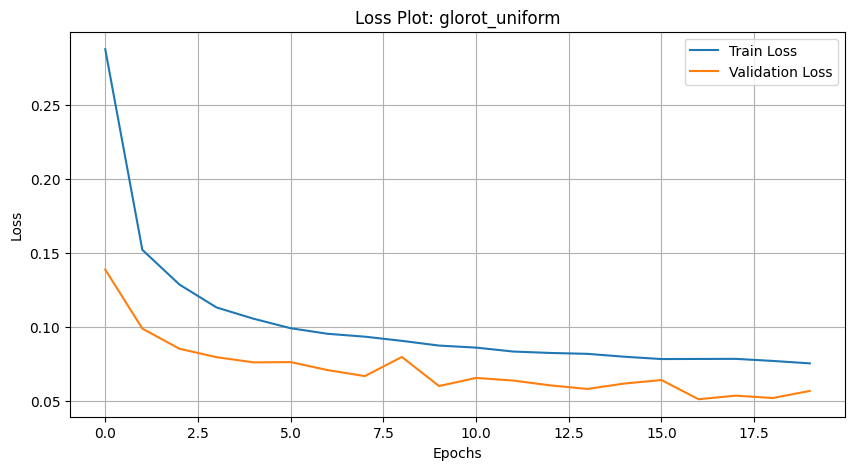

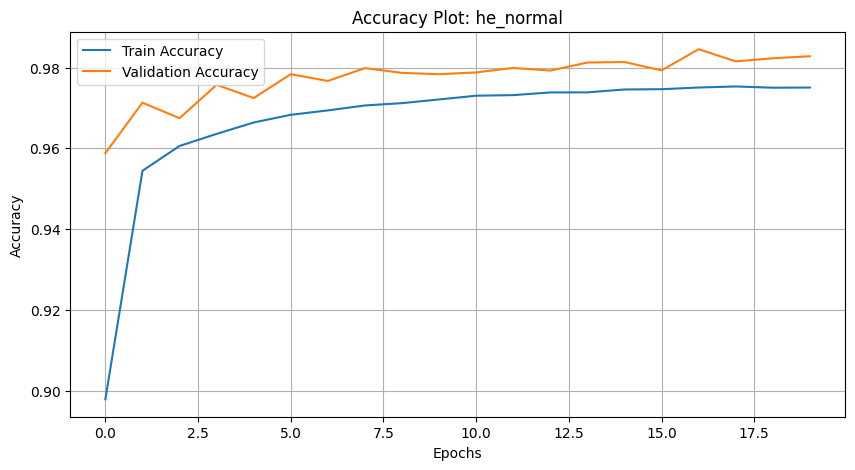

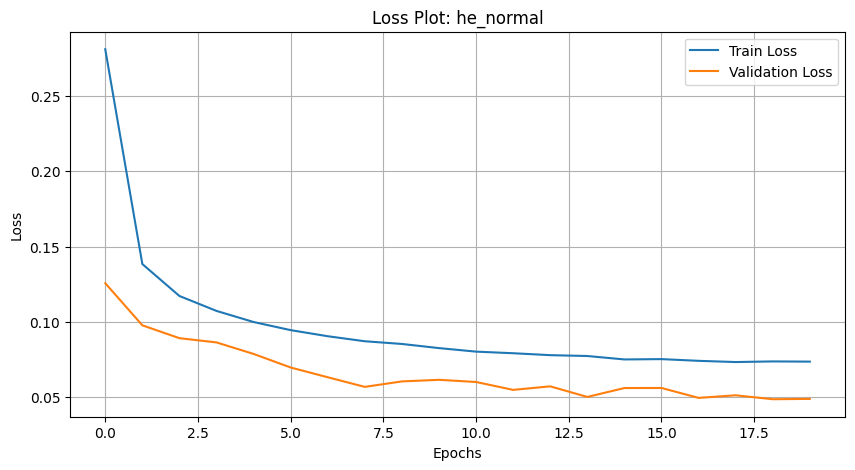

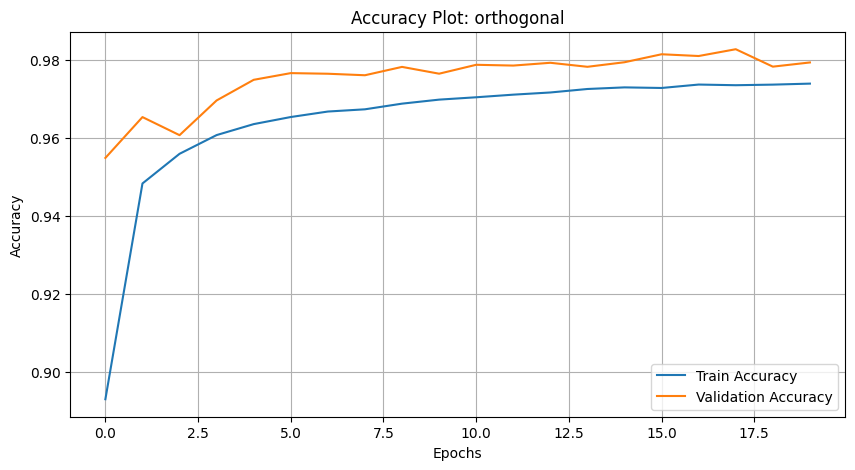

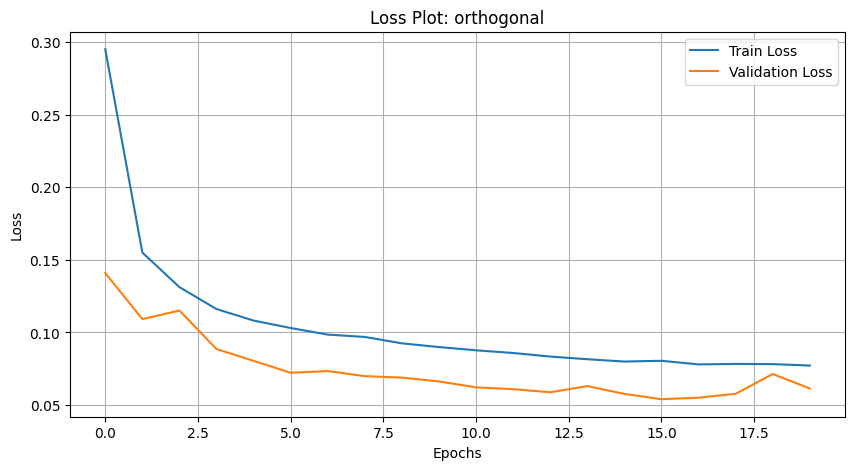

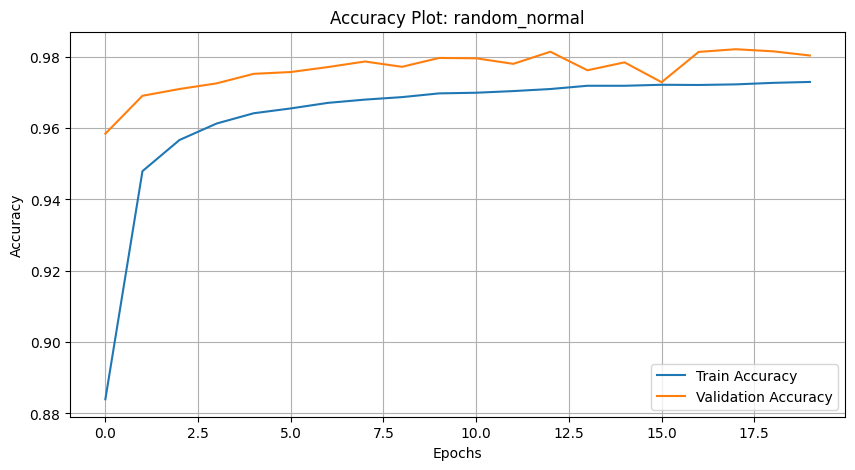

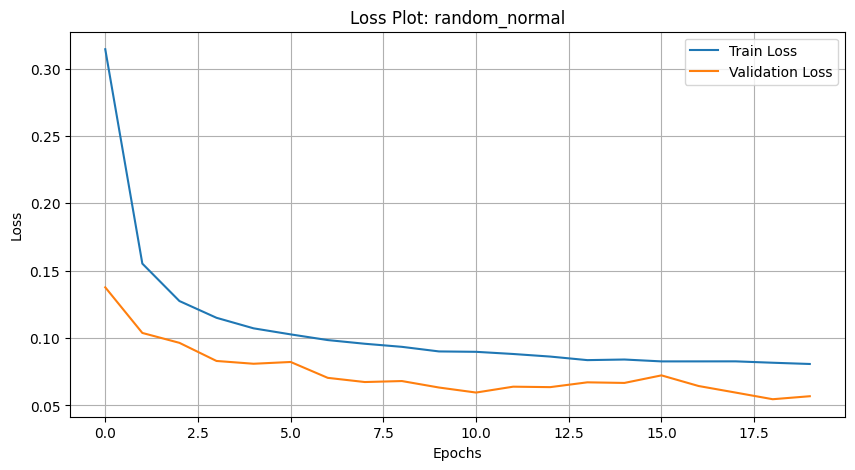

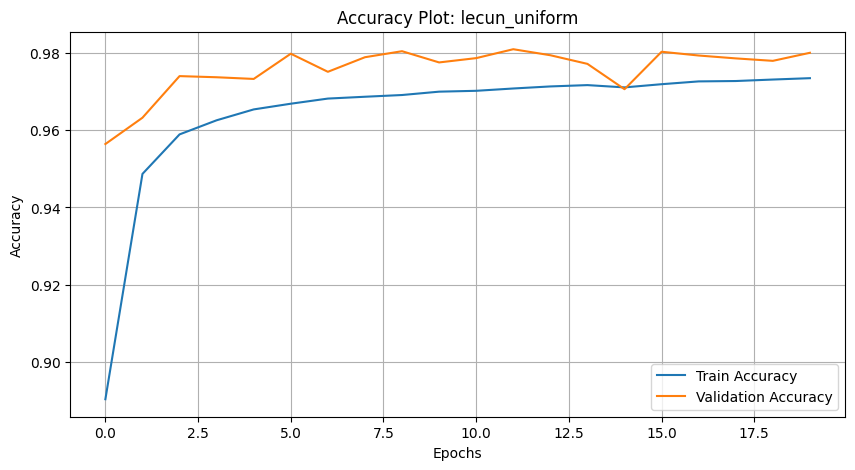

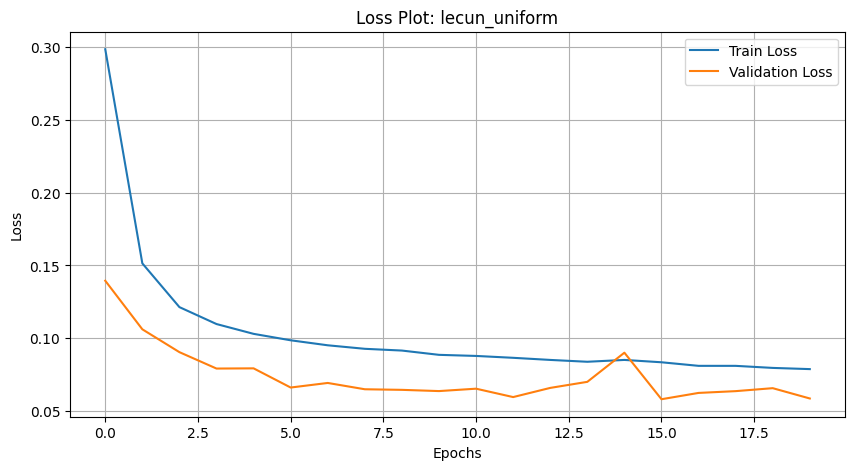

In [30]:
# To store results
history_dict = {}
test_accuracies = {}

for init_name, initializer in initializers.items():
    print(f"\nTraining with {init_name} initializer...\n")
    
    # Define the model with the current initializer
    model = Sequential([
        LSTM(128, activation='relu', 
             kernel_initializer=initializer,
             input_shape=(X_train.shape[1], X_train.shape[2]), 
             return_sequences=False),
        Dropout(0.4),
        Dense(64, activation='relu', kernel_initializer=initializer),
        Dense(5, activation='softmax', kernel_initializer=initializer)  
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model and save history
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20, 
        batch_size=32,
        verbose=1
    )

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"{init_name} Test Accuracy: {test_accuracy * 100:.2f}%\n")

    # Store the results
    history_dict[init_name] = history
    test_accuracies[init_name] = test_accuracy

# Plotting results for each initializer
for init_name, history in history_dict.items():
    # Accuracy Plot
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy Plot: {init_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Plot: {init_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

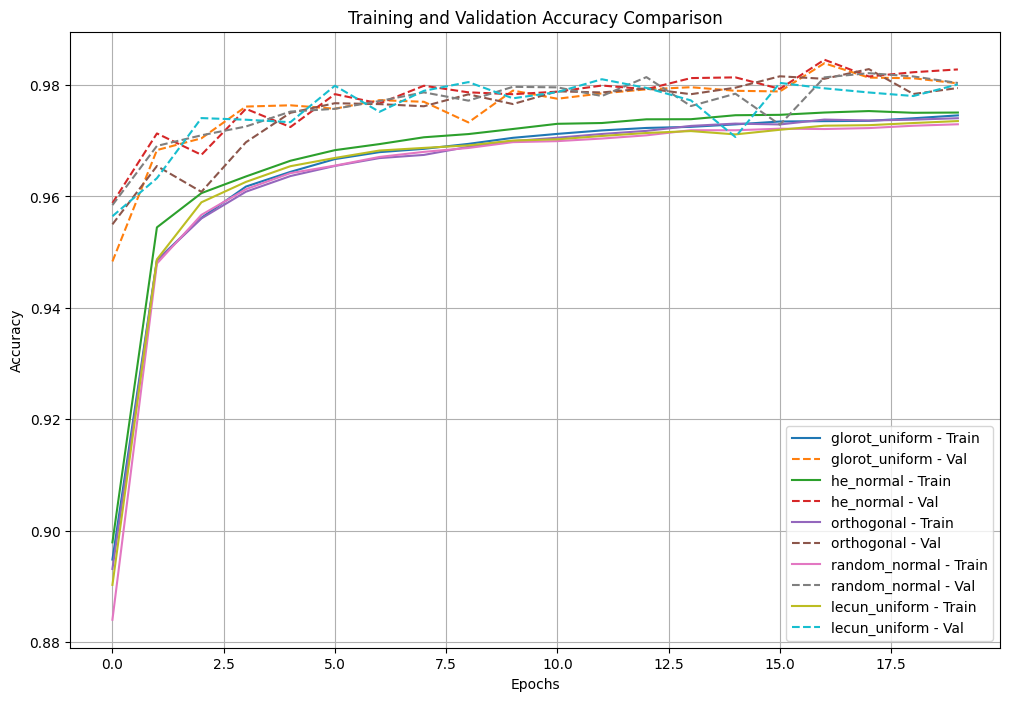

In [31]:

plt.figure(figsize=(12, 8))
for init_name, history in history_dict.items():
    plt.plot(history.history['accuracy'], label=f'{init_name} - Train')
    plt.plot(history.history['val_accuracy'], '--', label=f'{init_name} - Val')

plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



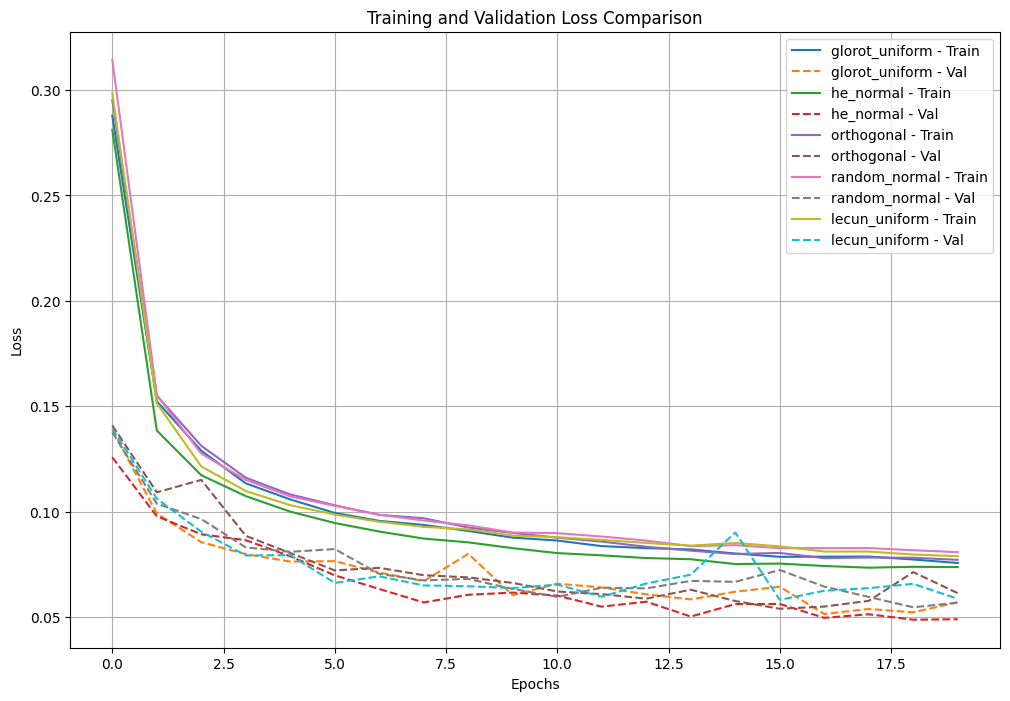

In [32]:

plt.figure(figsize=(12, 8))
for init_name, history in history_dict.items():
    plt.plot(history.history['loss'], label=f'{init_name} - Train')
    plt.plot(history.history['val_loss'], '--', label=f'{init_name} - Val')

plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# Print Final Test Accuracy Summary
for init_name, accuracy in test_accuracies.items():
    print(f'{init_name} Test Accuracy: {accuracy * 100:.2f}%')

glorot_uniform Test Accuracy: 98.01%
he_normal Test Accuracy: 98.27%
orthogonal Test Accuracy: 97.95%
random_normal Test Accuracy: 98.05%
lecun_uniform Test Accuracy: 98.01%


# Requirement 6: Predictions on Unseen Examples

In [34]:

unseen_data = np.array([[30.18, 44.18, 30.13, 43.45, 30.17, 44.18, 30.14, 43.45, 30.18, 44.18, 30.17, 43.45]])  # Single sample with multiple features


unseen_data_scaled = scaler.transform(unseen_data)


unseen_data_reshaped = unseen_data_scaled.reshape((unseen_data_scaled.shape[0], 1, unseen_data_scaled.shape[1]))


prediction = model.predict(unseen_data_reshaped)
predicted_class = np.argmax(prediction)


print(f"Predicted Class: {label_encoder.inverse_transform([predicted_class])[0]}")


X does not have valid feature names, but MinMaxScaler was fitted with feature names


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
Predicted Class: normal
